In [1]:
'''predictor level fusion'''
import load_data
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#load data
training_data = load_data.read_data("train.csv")
testing_data = load_data.read_data("test.csv")
testing_labels = load_data.read_data("submission.csv")
X_train, X_test = load_data.vectorize_data(training_data, testing_data)

Y_train = np.array(training_data)[:, -1]
Y_test = np.array(testing_labels)[:, -1]


In [2]:
#Kmeans
kmean = KMeans(n_clusters=2)
kmean.fit(X_train, Y_train)
Y_train_kmean = kmean.predict(X_train)
Y_pred_kmean = kmean.predict(X_test)

In [3]:
#knn
neighbors = list(range(1,30,5))

param_grid = {
    'n_neighbors' : neighbors,
    'p': [1, 2]
}

clf = KNeighborsClassifier()
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, n_jobs = -1)
grid_search.fit(X_train, Y_train)
knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'], p=grid_search.best_params_['p'])
knn.fit(X_train, Y_train)
Y_train_knn = knn.predict(X_train)
Y_pred_knn = knn.predict(X_test)

In [4]:
#random forest
param_grid = {
    'bootstrap': [True],
    'n_estimators': [100, 200, 300, 1000]
}
clf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, n_jobs = -1)
grid_search.fit(X_train, Y_train)
rf = RandomForestClassifier(max_depth=None, bootstrap= True, n_estimators=grid_search.best_params_['n_estimators'], n_jobs = -1)
rf.fit(X_train, Y_train)
Y_train_fr = rf.predict(X_train)
Y_pred_rf = rf.predict(X_test)

In [5]:
#svm
svm = SVC()
svm.fit(X_train, Y_train)

Y_train_svm = svm.predict(X_train)
Y_pred_smv = svm.predict(X_test)

In [6]:
#bpnn
param_grid = {
    'max_iter' : [1000],
    'activation': ['identity','logistic','relu','tanh'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'hidden_layer_sizes': [(10),(10,10),(10,10,10),(10,10,10,10)],
    'learning_rate_init': [0.001, 0.005, 0.01],
}

clf = MLPClassifier()
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, n_jobs = -1)
grid_search.fit(X_train, Y_train)

bpnn = MLPClassifier(hidden_layer_sizes=grid_search.best_params_['hidden_layer_sizes'], activation=grid_search.best_params_['activation'], learning_rate_init=grid_search.best_params_['learning_rate_init'], solver=grid_search.best_params_['solver'], max_iter=1000)
bpnn.fit(X_train, Y_train)
Y_train_bpnn = bpnn.predict(X_train)
Y_pred_bpnn = bpnn.predict(X_test)

In [52]:
X_train_fusion = np.vstack((Y_train_kmean,Y_train_knn,Y_train_fr,Y_train_svm,Y_train_bpnn)).T
X_train_fusion = X_train_fusion.astype(int, copy=False)
X_test_fusion = np.vstack((Y_pred_kmean,Y_pred_knn,Y_pred_rf,Y_pred_smv,Y_pred_bpnn)).T
X_test_fusion = X_test_fusion.astype(int, copy=False)
Y_train = Y_train.astype(int, copy=False)
Y_test = Y_test.astype(int, copy=False)

def performance(Y_pred, Y_test=Y_test):
    precision, recall, fscore, train_support = score(Y_test, Y_pred, pos_label=1, average='binary')
    print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(fscore,3), round(acs(Y_test,Y_pred), 3)))

    cm = confusion_matrix(Y_test, Y_pred)
    class_label = [0, 1]
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    return 0

NameError: name 'copy' is not defined

Precision: 0.927 / Recall: 0.525 / F1-Score: 0.67 / Accuracy: 0.778


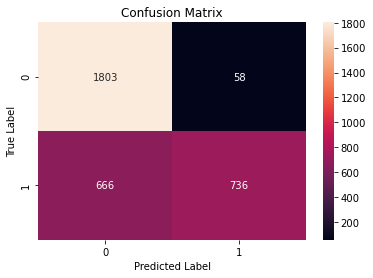

0

In [50]:
#fusion: majority voting
Y_pred_mv = np.greater(np.sum(X_test_fusion, axis = 1),3).astype(int)

performance(Y_pred_mv)

In [51]:
#fusion: naive bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
Y_pred_nb = gnb.fit(X_train_fusion, Y_train).predict(X_test_fusion)

performance(Y_pred_nb)

ValueError: Mix of label input types (string and number)

Precision: 0.826 / Recall: 0.665 / F1-Score: 0.737 / Accuracy: 0.796


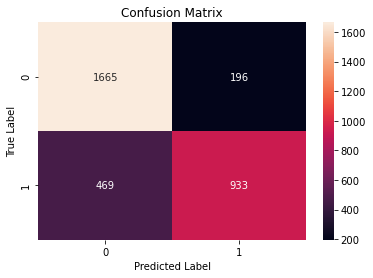

0

In [21]:
#fusion: logistic regression
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
Y_pred_lgr = lgr.fit(X_train_fusion, Y_train).predict(X_test_fusion)

performance(Y_pred_lgr)

Precision: 0.826 / Recall: 0.665 / F1-Score: 0.737 / Accuracy: 0.796


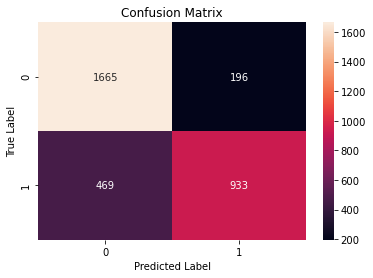

0

In [37]:
#fusion: random forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
Y_pred_rfc = rfc.fit(X_train_fusion, Y_train).predict(X_test_fusion)

performance(Y_pred_rfc)

Precision: 0.826 / Recall: 0.665 / F1-Score: 0.737 / Accuracy: 0.796


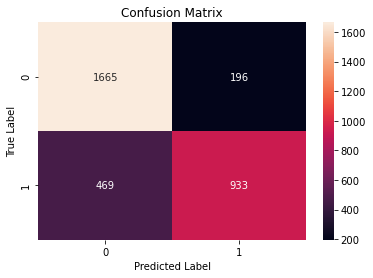

0

In [23]:
#fusion: gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
Y_pred_gb = gb.fit(X_train_fusion,Y_train).predict(X_test_fusion)

performance(Y_pred_gb)